In [1]:
import emat, numpy, pandas
emat.versions()

emat 0.2.5, ema_workbench 2.1.506, plotly 4.1.1


# Optimization Tools

Typically, transportation policy planning models will be used to
try to find policies that provide the "best" outcomes.  In a traditional
analytical environment, that typically means using models to find 
optimal outcomes for performance measures.

Transportation models as used in the TMIP-EMAT frawework are 
generally characterized by two important features: they are 
subject to significant exogenous uncertainties about the future
state of the world, and they include numerous performance measures
for which decision makers would like to see good outcomes. Therefore,
optimization tools applied to these models should be 
flexible to consider *multiple objectives*,
as well as be *robust* against uncertainty.

## Multi-Objective Optimization

With exploratory modeling, optimization is also often undertaken as a 
[multi-objective optimization](https://en.wikipedia.org/wiki/Multi-objective_optimization) exercise, where multiple
and possibly conflicting performance measures need to be addressed simultaneously. 
A road capacity expansion project is a good example of a multi-objective optimization 
problem. In such a situation, we want to expand the capacity of a roadway, both minimizing
the costs and maximizing the travel time benefits.  A smaller expansion project will cost less
but also provide lesser benefits.  Funding it with variable rate debt might 
decrease expected future costs but doing so entails more risk than fixed-rate debt.

One approach to managing a multi-objective optimization problem is to distill it 
into a single objective problem, by assigning relative weights to the various 
objectives.  For a variety of reasons, this can be difficult to accomplish in public policy environments that are common in transportation planning. 
Multiple stakeholders may have different
priorities and may not be able to agree on a relative weighting structure.  
Certain small improvements in a performance measure may be valued very differently 
if they tip the measure over a regulated threshold (e.g. to attain a particular 
mandated level of emissions or air quality).

Instead of trying to simplify a multi-objective into a simple-objective one,
an alternate approach is to preserve the multi-objective nature of the problem
and find a set or spectrum of different solutions, each of which solves the problem
at a different weighting of the various objectives.  Decision makers can then
review the various different solutions, and make judgements about the various
trade-offs implicit in choosing one path over another.

Within a set of solutions for this kind of problem, each individual solution is 
"[Pareto optimal](https://en.wikipedia.org/wiki/Pareto_efficiency)", such that
no individual objective can be improved without degrading at least one other
objective by some amount.  Thus, each of these solutions might be the "best"
policy to adopt, and exactly which is the best is left as a subjective judgement
to decision makers, instead of being a concretely objective evaluation based 
on mathematics alone.

## Robust Optimization

Robust optimization is a variant of the more traditional optimization
problem, where we will try to find policies that yield *good* outcomes
across a range of possible futures, instead of trying to find a policy
that delivers the *best* outcome for a particular future.

To conceptualize this, let us consider a decision where there are four
possible policies to choose among, a single exogenous uncertainty that
will impact the future, and a single performance measure that we would
like to mimimize.  We have a model that can forecast the performance 
measure, conditional on the chosen policy and the future value of the
exogenous uncertainty, and which gives us a forecasts as shown below.

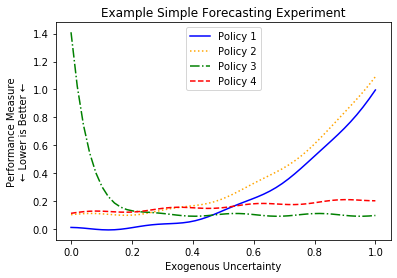

In [2]:
import numpy
from matplotlib import pyplot as plt
x = numpy.linspace(0,1)
y1 = x**3 + numpy.cos((x-3)*23)*.01
y2 = x**3 + .1 + numpy.sin((x-3)*23)*.01
y3 = 1.3*(1-x)**17 + numpy.cos((x-3)*23)*.01 + .1
y4 = numpy.sin((x-3)*23)*.01+0.16 + .1*(x-0.5)

linestyles = [
    dict(ls='-', c='blue'),
    dict(ls=':', c='orange'),
    dict(ls='-.', c='green'),
    dict(ls='--', c='red'),
]

fig, ax = plt.subplots(1,1)
ax.plot(x, y1, **linestyles[0], label="Policy 1")
ax.plot(x, y2, **linestyles[1], label="Policy 2")
ax.plot(x, y3, **linestyles[2], label="Policy 3")
ax.plot(x, y4, **linestyles[3], label="Policy 4")
ax.set_ylabel("Performance Measure\n← Lower is Better ←")
ax.set_xlabel("Exogenous Uncertainty")
ax.legend()
ax.set_title("Example Simple Forecasting Experiment")

plt.savefig("robust_example.png")
plt.show()

In a naive optimization approach, if we want to minimize the performance
measure, we can do so by selecting Policy 1 and setting the exogenous
uncertainty to 0.1.  Of course, in application we are able to select
Policy 1, but we are unable to actually control the exogenous uncertainty
(hence, "exogenous") and we may very well end up with a very bad result
on the right side of the figure.

We can see from the figure that, depending on the ultimate value for 
the exogenous uncertainty, either Policy 1 or Policy 3 might yield the
best possible value of the performace measure.  However, both of these
policies come with substantial risks as well -- in each Policy there are
some futures where the results are optimal, but there are also some 
futures where the results are exceptionally poor.

In contrast with these optimal policies, Policy 4 may be considered a 
"robust" solution.  Although there is no value of the exogenous 
uncertainty where Policy 4 yields the best possible outcome, there is
also no future where Policy 4 yields a very poor outcome.  Instead, across
all futures it is always generating a "pretty good" outcome.

Different expectations for the future may lead to different policy 
choices.  If the decision maker feels that low values of the exogenous
uncertainty are much more likely than high values, Policy 1 might be
the best policy to choose.  If high values of the exogenous uncertainty
are expected, then Policy 3 might be the best choice.  If there is not
much agreement on the probable future values of the exogenous uncertainty,
or if decision makers want to adopt a risk-averse stance, then Policy 4
might be the best choice.  

The remaining policy shown in the figure, Policy 2, is the lone holdout 
in this example -- there is no set of expectations about the future, or
attitudes toward risk, that can make this policy the best choice.  This
is because, no matter what the future value of the exogenous uncertainty
may be, the performance measure has a better outcome from Policy 1 than
from Policy 2.  In this circumstance, we can say that Policy 2 is 
"dominated" and should never be chosen by decision makers.

### Robustness Functions

To perform robust optimization in EMAT, we need a core model (or meta-model)
with defined input and output parameters, as well a set of functions called
"robustness measures" that define what a "robust" measure represents.  
As noted above, different expectations about future states of the world
can lead to different rankings of policy options.  In addition, different
attitudes towards risk can result in different robustness measures that are
derived from the same underlying modeled performance measures.  

For example, consider the *Example Simple Forecasting Experiment* shown above.
In this example, we could compute a robustness measure for each policy where
we calculate the maximum value of the performance measure across any possible
value of the exogenous uncertainty.  This value is shown in the first column
of robustness measures in the figure below, and under this measure Policy 4 is
far and away the best choice. 

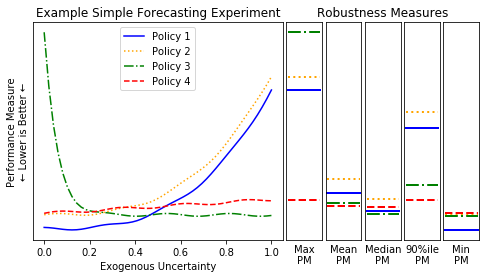

In [3]:
fig, ax = plt.subplots(
    1,6, sharey=True, 
    gridspec_kw=dict(width_ratios=[7,1,1,1,1,1], wspace=0.05,), 
    figsize=[8, 4.],
)


ax[0].plot(x, y1, **linestyles[0], label="Policy 1")
ax[0].plot(x, y2, **linestyles[1], label="Policy 2")
ax[0].plot(x, y3, **linestyles[2], label="Policy 3")
ax[0].plot(x, y4, **linestyles[3], label="Policy 4")
ax[1].plot([0,1], [y1.max()]*2, **linestyles[0], lw=2)
ax[1].plot([0,1], [y2.max()]*2, **linestyles[1], lw=2)
ax[1].plot([0,1],[y3.max()]*2, **linestyles[2],  lw=2)
ax[1].plot([0,1], [y4.max()]*2, **linestyles[3], lw=2)

ax[2].plot([0,1], [y1.mean()]*2, **linestyles[0], lw=2)
ax[2].plot([0,1], [y2.mean()]*2, **linestyles[1], lw=2)
ax[2].plot([0,1],[y3.mean()]*2, **linestyles[2],  lw=2)
ax[2].plot([0,1], [y4.mean()]*2, **linestyles[3], lw=2)

ax[3].plot([0,1], [numpy.median(y1)]*2, **linestyles[0], lw=2)
ax[3].plot([0,1], [numpy.median(y2)]*2, **linestyles[1], lw=2)
ax[3].plot([0,1], [numpy.median(y3)]*2, **linestyles[2],  lw=2)
ax[3].plot([0,1], [numpy.median(y4)]*2, **linestyles[3], lw=2)

ax[4].plot([0,1], [numpy.percentile(y1, 90)]*2, **linestyles[0], lw=2)
ax[4].plot([0,1], [numpy.percentile(y2, 90)]*2, **linestyles[1], lw=2)
ax[4].plot([0,1], [numpy.percentile(y3, 90)]*2, **linestyles[2],  lw=2)
ax[4].plot([0,1], [numpy.percentile(y4, 90)]*2, **linestyles[3], lw=2)

ax[5].plot([0,1], [y1.min()]*2, **linestyles[0], lw=2)
ax[5].plot([0,1], [y2.min()]*2, **linestyles[1], lw=2)
ax[5].plot([0,1], [y3.min()]*2, **linestyles[2], lw=2)
ax[5].plot([0,1], [y4.min()]*2, **linestyles[3], lw=2)


ax[0].set_ylabel("Performance Measure\n← Lower is Better ←")
ax[0].set_xlabel("Exogenous Uncertainty")
ax[0].legend()
ax[0].set_title("Example Simple Forecasting Experiment")
ax[3].set_title("Robustness Measures")
ax[1].set_xlabel("Max\nPM")
ax[2].set_xlabel("Mean\nPM")
ax[3].set_xlabel("Median\nPM")
ax[4].set_xlabel("90%ile\nPM")
ax[5].set_xlabel("Min\nPM")
ax[-1].yaxis.set_label_position("right")
for a in [1,2,3,4,5]:
    ax[a].set_xticks([])
    ax[a].set_yticks([])
plt.savefig("robust_measures.png")
plt.show()

The "maximum performance measure result" robustness function is a very
risk averse approach, as no consideration is given to the shape or distribution
of performance measure values other than the maximum.  Consider these same
policies shown if Policy 4 is not available. In this case, the next best 
policy under this robustness function is Policy 1, as it has the next lowest
maximum value.  However, when we look at
a comparison between Policies 1 and 3 in aggregate, we might easily conclude
that Policy 3 is a better choice overall: it is better than Policy 1 on average,
as judged by the mean, median, and 90th percentile measures.  The only reason 
Policy 3 appears worse than Policy 1 on the initial robustness function is that 
it has an especially poor outcome at one extreme end of the uncertainty 
distribution.  Depending on our attitude towards risk on this performance measure,
we may want to consider using some of these alternative robustness functions.
An additional consideration here is that the various robustness measures
in this example case are all unweighted measures: they implicitly assume a 
uniform probability distribution for the entire range of possible values for
the exogenous uncertainty.  If we are able to develop a probability distribution
on our expectations for the future values of the exogenous uncertainties,
we can use that probability distribution to weight the robustness functions
appropriately, creating more meaningful values, particularly for the non-extreme
value robustness functions (i.e., everything except the min and max).

# Mechanics of Using Optimization

## Policy Optimization: Search over Levers

The simplest optimization tool available for TMIP-EMAT users is 
a *search over policy levers*, which represents multi-objective
optimization, manipulating policy lever values to find a Pareto
optimal set of solutions, holding the exogenous uncertainties
fixed at a particular value for each uncertainty (typically at 
the default values).  This is often a useful first step
in exploratory analysis, even if your ultimate goal is to 
eventually undertake a robust optimization analysis.  This less
complex optimization can give insights into tradeoffs between
performance measures and reasonable combinations of policy levers.

To demonstrate a search over levers, we'll use the Road Test 
example model.

In [2]:
import emat.examples
scope, db, model = emat.examples.road_test()

The scope defined for a model in TMIP-EMAT will already provide
information about the preferred directionality of performance
measures (i.e., 'maximize' when larger values are better,
'minimize' when smaller values are better, or 'info' when we
do not have a preference for bigger or smaller values, but we 
just want to be tracking the measure).  We can see these
preferences for any particular performance measure by inspecting
the scope definition file, or by using the `info` method of
`emat.Measure` instances.

In [3]:
scope['net_benefits'].info()

net_benefits:
  kind: maximize


To conduct an optimization search over levers, we'll use the 
`optimize` method of the TMIP-EMAT model class, setting the
`search_over` argument to `'levers'`.  In this example, we will
set the number of function evaluations (`nfe`) to 10,000, although
for other models you may need more or fewer to achieve a good, 
well converged result.  In a Jupyter notebook environment, 
we can monitor convergence visually in real time in the figures
that will appear automatically.

In [4]:
result = model.optimize(
    nfe=10_000, 
    searchover='levers', 
    check_extremes=1,
    cache_file='./optimization_cache/road_test_search_over_levers.gz',
)

ConvergenceMetrics(children=(FigureWidget({
    'data': [{'fill': 'tonexty',
              'line': {'shape': '…

The `optimize` method returns an `OptimizationResult` object, 
which contains the resulting solutions, as well as some information
about how they were derived.  We can review the raw values of the
solutions as a pandas DataFrame, or see the scenario values used 
to generate these solutions.

In [5]:
result.result.head()

,expand_capacity,amortization_period,debt_type,interest_rate_lock,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion
0,50.014613,50,Paygo,True,61.777085,7.222915,54.171861,-73.429075,127.600936
1,6.000196,50,Paygo,True,67.128790,1.871210,14.034073,-1.274065,15.308138
2,34.576642,50,Paygo,False,62.743871,6.256129,46.920964,-41.293493,88.214457
3,14.079862,50,Paygo,True,65.313817,3.686183,27.646376,-8.275198,35.921574
4,2.947572,50,Paygo,True,68.012685,0.987315,7.404862,-0.115200,7.520062


In [6]:
result.scenario

Scenario({'alpha': 0.15, 'beta': 4.0, 'input_flow': 100, 'value_of_time': 0.075, 'unit_cost_expansion': 100, 'interest_rate': 0.03, 'yield_curve': 0.01})

We can visualize the set of solutions using a
[parallel coordinates](https://en.wikipedia.org/wiki/Parallel_coordinates) 
plot.  This figure is composed of a number of vertical axes, one for each 
column of data in the results DataFrame.  Each row of the DataFrame is
represented by a chord that connects across each of the vertical axes.

By default, the axes representing performace measures to be minimized are
inverted in the parallel coordinates, such that moving up along any 
performance measure axis results in a "better" outcome for that performance
measure.

In the figure below, we can quickly see that all the all of the Pareto
optimal policy solutions for our reference scenario share an amortization
period of 50 years and a debt type of 'Paygo'.  By contrast, the set of 
solutions include multiple different values for the expand capacity lever,
ranging from 0 to 100.  These different values offer possible tradeoffs 
among the performance measures: lower levels of capacity expansion (shown
in yellow) will maximize net benefits and minimize the cost of the project,
but they will also fail to provide much travel time savings.  Conversely,
larger levels of capacity expansion will provide better travel time savings, 
but will not perform as well on costs.  It is left up the the analysts and
decision makers to judge what tradeoffs to make between these conflicting
goals.

In [7]:
result.par_coords()

ParCoordsViewer(children=(FigureWidget({
    'data': [{'dimensions': [{'label': '(L) expand_capacity',
       …

## Worst Case Discovery: Search over Uncertainties

We can apply the same multiobjective optimization tool in reverse to 
study the worst case outcomes from any particular set of policy lever
settings.  To do so, we switch out the `searchover` argument from
`'levers'` to `'uncertainties'`, and set `reverse_targets` to True,
which will tell the optimization engine to search for the worst outcomes
instead of the best ones.  We'll often also want to override the reference
policy values with selected particular values, although it's possible
to omit this reference argument to search for the worst case scenarios
under the default policy lever settings.

In [8]:
worst = model.optimize(
    nfe=10_000, 
    searchover='uncertainties', 
    reverse_targets = True,
    check_extremes=1,
    cache_file='./optimization_cache/road_test_search_over_uncs.gz',
    reference={
        'expand_capacity': 100.0, 
        'amortization_period': 50, 
        'debt_type': 'PayGo', 
        'interest_rate_lock': False,
    }
)

ConvergenceMetrics(children=(FigureWidget({
    'data': [{'fill': 'tonexty',
              'line': {'shape': '…

In [9]:
worst.par_coords()

ParCoordsViewer(children=(FigureWidget({
    'data': [{'dimensions': [{'label': '(X) alpha',
                 …

## Using Robust Optimization

As discussed above, implementing robust optimization requires the
definition of relevant robustness functions.  Because the functional
form of these functions can be so many different things depending on
the particular application, TMIP-EMAT does not implement a mechanism
to generate them automatically.  Instead, it is left to the analyst to
develop a set of robustness functions that are appropriate for each
application.

Each robustness function represents an aggregate performance measure,
calculated based on the results from a group of individual runs of the
underlying core model (or meta-model).  These runs are conducted with
a common set of policy lever settings, and a variety of different 
exogenous uncertainty scenarios.  This allows us to create aggregate 
measures that encapsulate information from the distribution of possible
outcomes, instead of for just one particular future scenario.

A robust measure is created in TMIP-EMAT using the same `Measure` class
used for performace measures that are direct model outputs.  Like any 
other measure, they have a `name` and `kind` (minimize, maximize, or info).
The names used for robust measures must be unique new names that are 
not otherwise used in the model's scope, so you cannot use the same name
as an existing performance measure. Instead, the names can (and usually 
should) be descriptive variants of the existing performance measures. 
For example, if an existing performance measure is `'net_benefits'`,
you can name a robust measure `'min_net_benefits'`.

In addition to the `name` and `kind`, robust measures have two important
additional attributes: a `variable_name`, which names the underlying
performance measure upon which this robust measure is based, and a
`function` that describes how to aggregate the results.  The function
should be a callable function, which accepts an array of performance
measure values as its single argument, and returns a single numeric
value that is the robust measure.  For example, the code below will 
create a robust measure that represents the minimum net benefit across 
all exogenous uncertainty scenarios.

In [10]:
from emat import Measure

minimum_net_benefit = Measure(
    name='Minimum Net Benefits',
    kind=Measure.MAXIMIZE,
    variable_name='net_benefits',
    function=min,
)

As suggested earlier, this measure might be too sensitive to outliers
in the set of exogenous uncertainty scenarios.  We can address this 
by creating a different robust measure, based on the same underlying
performance measure, but which is based on the mean instead of the 
minimum value.

In [11]:
expected_net_benefit = Measure(
    name='Mean Net Benefits',
    kind=Measure.MAXIMIZE,
    variable_name='net_benefits',
    function=numpy.mean,
)

Or we can adopt an intermediate approach, focusing on the 5th percentile
instead of the minimum, which avoids being overly sensitive to the 
most extreme tail ends of the distribution, but maintains a fairly 
risk-averse robustness approach.

Note that normally, the `numpy.percentile` function requires two arguments
instead of one: the array of values, and the target percentile value.
Since the `function` of the robust measure needs to accept only a single 
argument, we can inject the `q=5` argument here using 
[functools.partial](https://docs.python.org/3/library/functools.html#functools.partial).

In [12]:
import functools

pct5_net_benefit = Measure(
    '5%ile Net Benefits',
    kind = Measure.MAXIMIZE,
    variable_name = 'net_benefits', 
    function = functools.partial(numpy.percentile, q=5), 
)

We can also capture robustness measures that are not statistical versions
of the performance measure (that can be contrasted directly with the 
performance measure outputs, like the mean or median), but rather more abstract 
measures, like the percentage of scenarios where the performace measure 
meets some target value.  For example, we can compute the percentage of scenarios
for the road test example where the net benefits are negative.  To do so,
we will use the `percentileofscore` function from the `scipy.stats` package.
For this function, set the `kind` argument to `'strict'` to count only strictly
negative results -- not scenarios where the net benefits are exactly zero -- or
to `'weak'` to count all non-positive results.

In [13]:
from scipy.stats import percentileofscore

neg_net_benefit = Measure(
    'Possibility of Negative Net Benefits',
    kind = Measure.MINIMIZE,
    variable_name = 'net_benefits', 
    function = functools.partial(percentileofscore, score=0, kind='strict'), 
)

We can of course also create robust measures based on other 
performance measures in the core model.  For example, in the 
Road Test model the total cost of the capacity expansion is
subject to some uncertainty, and we may want to make policy
choices not just to maximize net benefits but also trying to
keep costs in check.

In [14]:
pct95_cost = Measure(
    '95%ile Capacity Expansion Cost',
    kind = Measure.MINIMIZE,
    variable_name = 'cost_of_capacity_expansion', 
    function = functools.partial(numpy.percentile, q = 95), 
)

We may also be interested in finding policies that will maximize the expected time savings.  
Although we can easily conceptualize that these two goals are in opposition (increasing time
savings pretty obviously goes hand in hand with increasing cost) we will be able to use
the results of this robust optimization to visualize the tradeoffs and try to find an 
appropriate balance.

In [15]:
expected_time_savings = Measure(
    'Expected Time Savings',
    kind = Measure.MAXIMIZE, 
    variable_name = 'time_savings', 
    function = numpy.mean,
)

In [16]:
from emat.util.distributed import get_client

In [17]:
robust_result = model.robust_optimize(
    robustness_functions=[
        expected_net_benefit,
        pct5_net_benefit,
        neg_net_benefit,
        pct95_cost,
        expected_time_savings,
    ],
    scenarios=250,
    nfe=25_000,
    check_extremes=1,
    evaluator=get_client(),
    cache_file='./optimization_cache/road_test_robust_search.gz',
)

ConvergenceMetrics(children=(FigureWidget({
    'data': [{'fill': 'tonexty',
              'line': {'shape': '…

In [18]:
robust_result.par_coords()

ParCoordsViewer(children=(FigureWidget({
    'data': [{'dimensions': [{'label': '(L) expand_capacity',
       …

### Constraints

The robust optimization process can be constrained to only include 
solutions that satisfy certain constraints. These constraints can 
be based on the policy lever parameters that are contained in the 
core model, the aggregate performance measures identified in the 
list of robustness functions, or some combination of levers and 
aggregate measures.  Importantly, the constraints *cannot* be imposed 
on the exogenous uncertainties, nor directly on the output measures 
from the core models (or the equivalent meta-model). This is because 
the robust version of the model aggregates a number of individual 
core model runs, and effectively hides these two components from 
the optimization engine.  

One way to work around this limitation, at least on the output measures, 
is to write robustness functions that transmit the relevant output 
measures through the aggregation process. For example, to constrain 
the robust search only to instances where a particular output measure 
is always positive, then write a robustness function that takes the 
*minimum* value of the targeted performance measure, and write a 
constraint that ensures that the minimum value is always positive.  
This approach should be used with caution, however, as it may severely 
limit the search space.

For the road test example, we can define some constraints to consider 
solutions that are within the limited search space. To do so, we will use the 
`Constraint` class.  

In [19]:
from emat import Constraint

Each `Constraint` needs to have a unique name
(i.e. not the same as anything else in the scope or any robust
measure).  Each `Constraint` is also defined by one or more 
`parameter_names` and/or `outcome_names`, plus a `function` that will be used to 
determine whether the constraint is violated.  The `function`
should accept positional values for each of the `parameter_names` 
and `outcome_names`, in order, and return 0 if the constraint is not
violated, and a positive number if it is violated.

Two convenient class methods are provided within the `Constraint` class:
`must_be_less_than` and `must_be_greater_than`, which can simplify
the creation and legibility of simple constraints on a single
parameter or outcome.  Each take a single argument, the threshold
of the constraint.

In [20]:
c_min_expansion = Constraint(
    "Minimum Capacity Expansion",
    parameter_names="expand_capacity",
    function=Constraint.must_be_greater_than(10),
)

c_positive_mean_net_benefit = Constraint(
    "Minimum Net Benefit",
    outcome_names = "Mean Net Benefits",
    function = Constraint.must_be_greater_than(0),
)

It is also possible to impose constraints based on a combination 
of inputs and outputs. For example, suppose that the total funds 
available for pay-as-you-go financing are only 3,000. We may thus 
want to restrict the robust search to only solutions that are almost 
certainly within the available funds at 99% confidence (a robustness
measure that is an output we can construct) 
but only if the Paygo financing option is used (a model input). 
This kind of constraint can be created by giving both 
`parameter_names` and `outcomes_names`, and writing a constraint 
function that takes two arguments.

In [21]:
pct99_present_cost = Measure(
    '99%ile Present Cost',
    kind=Measure.INFO,
    variable_name='present_cost_expansion',
    function=functools.partial(numpy.percentile, q=99),
)

c_max_paygo = Constraint(
    "Maximum Paygo",
    parameter_names='debt_type',
    outcome_names='99%ile Present Cost',
    function=lambda i,j: max(0, j-3000) if i=='Paygo' else 0,
)

The constraints are then passed to the `robust_optimize` method in addition to the 
other arguments.

In [22]:
robust_constrained = model.robust_optimize(
    robustness_functions=[
        expected_net_benefit,
        pct5_net_benefit,
        neg_net_benefit,
        pct95_cost,
        expected_time_savings,
        pct99_present_cost,
    ],
    constraints = [
        c_min_expansion, 
        c_positive_mean_net_benefit, 
        c_max_paygo,
    ],
    scenarios=250,
    nfe=10_000,
    check_extremes=1,
    evaluator=get_client(),
    cache_file='./optimization_cache/road_test_robust_search_constrained.gz',
)

ConvergenceMetrics(children=(FigureWidget({
    'data': [{'fill': 'tonexty',
              'line': {'shape': '…

In [23]:
robust_constrained.par_coords()

ParCoordsViewer(children=(FigureWidget({
    'data': [{'dimensions': [{'label': '(L) expand_capacity',
       …